In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import csv

from scipy.misc     import imsave
from keras          import metrics
from PIL            import Image

import tensorflow as tf
import keras
from keras import layers
from keras.models                      import Model, load_model, Sequential
from keras.applications.vgg16          import VGG16
from keras.applications.vgg16          import decode_predictions
from keras.utils.np_utils              import to_categorical

import keras.backend     as K
import numpy             as np
import matplotlib.pyplot as plt

from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, SaliencyMapMethod
from cleverhans.utils import other_classes


Using TensorFlow backend.


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
def limit_mem():
    cfg                          = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))

In [4]:
limit_mem()

In [5]:
def create_title(category):
    return '"%s"' % (category) 

In [6]:
def generate_title(model, array):
    prediction = model.predict(array).argmax()
    category = labels[prediction]
    return create_title(category)

# Loading prerequired variables

## Clean file

In [7]:
filename = '../../Images/stop2.jpeg'

(1, 100, 100, 3)


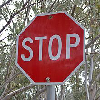

In [8]:
original_pic   = Image.open(filename).resize((100, 100))
original_array = np.expand_dims(np.array(original_pic), 0)
print(original_array.shape)
original_pic

## Labels

In [9]:
def readTrafficSigns(file_path):
    labels = [] # corresponding labels
    if os.path.isfile(file_path):
        with open(file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',') # csv parser for annotations file 
            # loop over all images in current annotations file
            for row in csv_reader:
                labels.append(row[1]) # the second column is the label
            csv_file.close()
    return labels[1:]

In [10]:
labels = readTrafficSigns("../../VGG16/signnames.csv")

# Goal

The goal of this notebook is to implement the "fast gradient sign method" presented in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572). This method is used to modify classical samples that a deep neural network trained classification will fail to classify properly.

![fgsm idea](http://karpathy.github.io/assets/break/breakconv.png "Fast Gradient Sign Method")

The idea of this method is to take a sample, ask the network to classify it, compute the gradient of the loss in function of the input pixels and update the picture by a small amount in the direction of the gradient. This direction is opposite to the one that would increase the score for the correct class.

We transform the image according to the VGG16 requirements. It consists in substracting the mean value for each channel and reversing the order of the channels. 

In [11]:
imagenet_mean      = np.array([123.68, 116.779, 103.939], dtype = np.float32)
preprocess         = lambda x: (x - imagenet_mean)
deprocess          = lambda x: (x + imagenet_mean)
preprocessed_array = preprocess(original_array)

# VGG loading

## Loading Fine-tuned VGG16 model

In [12]:
model = load_model('../../Models/VGG16/model_pur_transfer_GTSRB_79.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

### Plotting the model

In [13]:
#from keras.utils.vis_utils import plot_model
# plot_model(model,to_file='model_plot.png', show_layer_names=True)

Now let's ask the network what he sees in the picture. 

In [14]:
# Generating a one hot prediction np array and tensor for fgsm_params
one_hot_pred = model.predict(preprocessed_array)
pred = one_hot_pred.argmax()
tensor_pred = tf.convert_to_tensor(one_hot_pred,dtype=np.float32)

# Generating a one hot target np array and tensor for fgsm_params
one_hot_target = np.zeros((1, 43), dtype=np.float32)
# Class 2 is a Speed Limit 50km/h
one_hot_target[0, 2] = 1
tensor_target = tf.convert_to_tensor(one_hot_target,dtype=np.float32)

# Adversarial example generation

Now we try to confuse the network by modifying the stop roadsign picture. We generate the adversarial sample using `Cleverhans` library.

## FGSM

In [15]:
fgsm_params = {
    'eps': 0.005,
#    'y' : tensor_pred,
#    'y_target' : tensor_target,
    'clip_min': 0.,
    'clip_max': 1.
  }
# Initialize the Fast Gradient Sign Method (FGSM) attack object
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap)

# Converting the preprocessed array to a tensor for the fgsm.generate() function
tensor_preprocessed_array = tf.convert_to_tensor(preprocessed_array,dtype=np.float32)

#Generating the adversarial sample using Cleverhans library
adv_clever = fgsm.generate(tensor_preprocessed_array, **fgsm_params)
# Converting the tensor back to a np array
np_adv_clever = K.eval(K.variable(adv_clever))


#Adding the perturbation to the image and deprocessing it
modified_array  = preprocessed_array + np_adv_clever
deprocessed_array = np.clip(deprocess(modified_array), 0., 255.).astype(np.uint8)
pred_adv_clever = model.predict(deprocessed_array).argmax()

Clean prediction : Stop
Avdersarial prediction : Stop


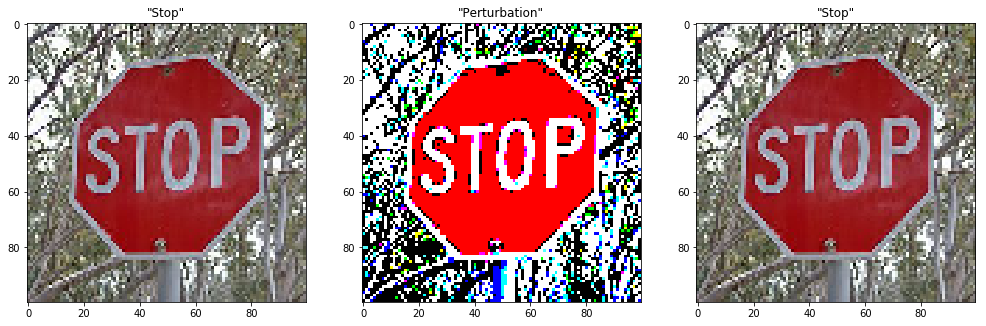

In [16]:
title_original     = create_title(labels[pred])
title_perturbation = create_title("Perturbation")
title_modified     = create_title(labels[pred_adv_clever])

plt.figure(figsize = (17, 17))
plt.subplot(1, 3, 1)
plt.imshow(original_array[0])
plt.title(title_original)
plt.subplot(1, 3, 2)
plt.imshow(np_adv_clever[0])
plt.title(title_perturbation)
plt.subplot(1, 3, 3)
plt.imshow(deprocessed_array[0])
plt.title(title_modified)

print("Clean prediction : %s\nAvdersarial prediction : %s"%(labels[pred],labels[pred_adv_clever]))


## JSMA

wrap = KerasModelWrapper(model)

jsma = SaliencyMapMethod(wrap)
jsma_params = {'theta': 1., 'gamma': 0.1,
               'clip_min': 0., 'clip_max': 1.,
               'y_target': None}

figure = None
print('--------------------------------------')
# We want to find an adversarial example for each possible target class
# (i.e. all classes that differ from the label given in the dataset)
current_class = pred
target_classes = other_classes(43, current_class)

# /!\ DOES NOT WORK /!\

# Loop over all target classes
for target in target_classes:
    print('Generating adv. example for target class %i' % target)

    # This call runs the Jacobian-based saliency map approach
    one_hot_target = np.zeros((1, 43), dtype=np.float32)
    one_hot_target[0, target] = 1
    jsma_params['y_target'] = tf.convert_to_tensor(one_hot_target, dtype=np.float32)
    print(type(jsma_params['y_target']))
    tensor_preprocessed_array = tf.convert_to_tensor(preprocessed_array,dtype=np.float32)
    adv_jsma = jsma.generate(tensor_preprocessed_array, **jsma_params)
    np_adv_jsma = K.eval(K.variable(adv_jsma))

# Check if success was achieved
res = int(model_argmax(sess, x, preds, adv_x) == target)
